# <a name="config"></a>Кофигурация

Эксперименты проводились на машине следующей конфигурации (1 CPU):

* Number of cores: 4
* Name: Intel Core i5 2400  
* Codename: Sandy Bridge  
* Specification: Intel(R) Core(TM) i5-2400 CPU @ 3.10GHz
* L1 Data cache: 4 x 32 KBytes, 8-way set associative, 64-byte line size  
* L1 Instruction cache: 4 x 32 KBytes, 8-way set associative, 64-byte line size  
* L2 cache: 4 x 256 KBytes, 8-way set associative, 64-byte line size  
* L3 cache: 6 MBytes, 12-way set associative, 64-byte line size

\**данные были экспортированы из CPU-Z*

# Симулятор кеша

Исходники кеша находятся полностью в файле [__cache.h__](cache.h). Кеш одноуровневый, принимает в качестве параметров размер памяти, размер кеш-линии и число каналов; кеш поддерживает две политики вытеснения: LRU и RR. В файлах [__mul.cpp__](mul.cpp) и [__trans.cpp__](trans.cpp) представлены соответственно простые реализации операций перемножения и транспонирования матриц. В файлах [__mul-cache.cpp__](mul-cache.cpp) и [__trans-cache.cpp__](trans-cache.cpp) находится модифицированный код из вышеуказанных файлов, интегрирующий в себя функциональность написанного кеша. 

Файлы отчетов для написанного кеша имеют формат: 
    
    размерность матрицы
    относительное число кеш-промахов
    длина данных для статистики
    данные для статистики: [{время жизни кеш-линии до вытеснения:число таких кеш-линий}]

## Выбор параметров для симулятора

Первоначально был произведен тестовый запуск умножения матриц под Valgrind и написанным симулятором (отчеты в файлах [__mul-cache-lru-LL6.txt__](mul-cache-lru-LL6.txt) и [__valgrind-mul-LL6.txt__](valgrind-mul-LL6.txt)). Valgrind запускался без параметров, для симулятора были заданы параметры, совпадающие с характеристиками L3 уровня кеша из [__Конфигурации__](#config). Рассматривались размерности 1023 и 1024. Ни Valgrind, ни собственный симулятор в этом случае не обнаружили проблем c чтением из кеша. Поэтому в дальнейшем при проведении тестов для Valgrind размер последнего уровня кеша задавался равным не 6 MB, а 3 MB. Аналогично, при запуске симулятора размер кеша выставлялся 3 MB.

## Анализ количества кеш-промахов

Распарсим вывод Valgrind и нашего симулятора кеша.

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import numpy as np

import re


n = (1023, 1024, 1025, 1040, 1041, 1050, 1100)
valgr_x_mr = []
valgr_t_mr = []
sim_x_lru_mr = []
sim_x_lru_stats = [([], []), ([], []), ([], []), ([], []), ([], []), ([], []), ([], [])]
sim_x_rr_mr = []
sim_x_rr_stats = [([], []), ([], []), ([], []), ([], []), ([], []), ([], []), ([], [])]
sim_t_lru_mr = []
sim_t_lru_stats = [([], []), ([], []), ([], []), ([], []), ([], []), ([], []), ([], [])]
sim_t_rr_mr = []
sim_t_rr_stats = [([], []), ([], []), ([], []), ([], []), ([], []), ([], []), ([], [])]

def parse_valgrind_output(filename, mr):
    p = re.compile("^.*LLd miss rate:[^\(]*\(\s*([\d\.]*)%.*$")
    with open(filename, "r") as f:
        for l in f:
            m = p.match(l)
            if m is not None:
                mr.append(float(m.group(1)))
parse_valgrind_output("valgrind-mul.txt", valgr_x_mr)
parse_valgrind_output("valgrind-trans.txt", valgr_t_mr)

# parse simulator output
def parse_sim_output(filename, mr, stats):
    with open(filename, "r") as f:
        for i in xrange(7):
            f.next()# n
            mr.append(100 * float(f.next()))# cache-miss rate, %
            stats_len = int(f.next())# stats length
            for j in xrange(stats_len):
                tkns = f.next().split(",");
                stats[i][0].append(int(tkns[0]))
                stats[i][1].append(int(tkns[1]))
parse_sim_output("mul-cache-lru.txt", sim_x_lru_mr, sim_x_lru_stats)
parse_sim_output("mul-cache-rr.txt", sim_x_rr_mr, sim_x_rr_stats)
parse_sim_output("trans-cache-lru.txt", sim_t_lru_mr, sim_t_lru_stats)
parse_sim_output("trans-cache-rr.txt", sim_t_rr_mr, sim_t_rr_stats)

На рисунках ниже представлены результаты анализа количества кеш-промахов для операций перемножения и транспонирования матриц. Рассматривается набор размерностей 1023, 1024, 1025, 1040, 1041, 1050, 1100.

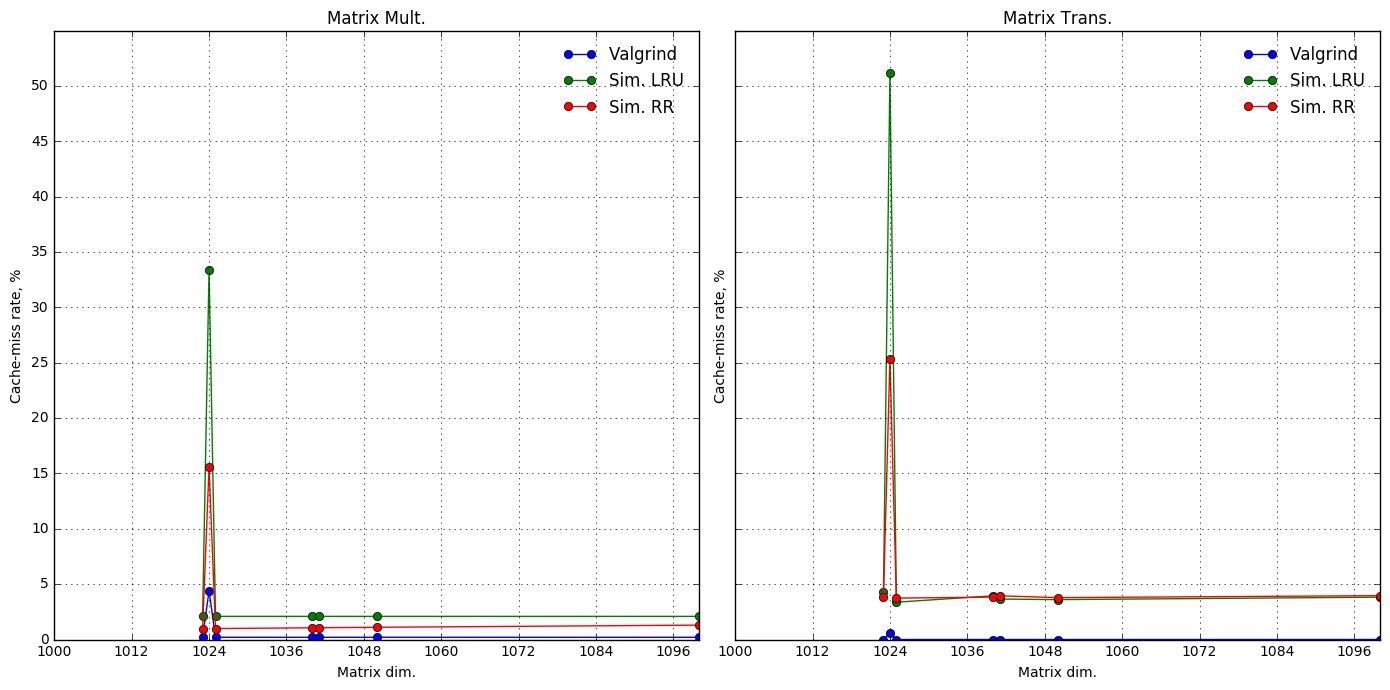

In [2]:
fig, axes = plt.subplots(1, 2, sharey="row", figsize=(14,7))
# matrix multiplication
axes[0].set_title("Matrix Mult.")
axes[0].plot(n, valgr_x_mr, label="Valgrind", marker="o")
axes[0].plot(n, sim_x_lru_mr, label="Sim. LRU", marker="o")
axes[0].plot(n, sim_x_rr_mr, label="Sim. RR", marker="o")
axes[0].set_xlabel("Matrix dim.")
axes[0].set_xticks(range(1000, 1100, 12))
axes[0].set_xlim([1000, 1100])
axes[0].set_ylabel("Cache-miss rate, %")
axes[0].set_yticks(range(0, 55, 5))
axes[0].set_ylim([0, 55])
axes[0].legend(loc='best', frameon=False)
axes[0].grid(True)
# matrix transpose
axes[1].set_title("Matrix Trans.")
axes[1].plot(n, valgr_t_mr, label="Valgrind", marker="o")
axes[1].plot(n, sim_t_lru_mr, label="Sim. LRU", marker="o")
axes[1].plot(n, sim_t_rr_mr, label="Sim. RR", marker="o")
axes[1].set_xlabel("Matrix dim.")
axes[1].set_xticks(range(1000, 1100, 12))
axes[1].set_xlim([1000, 1100])
axes[1].set_ylabel("Cache-miss rate, %")
axes[1].legend(loc='best', frameon=False)
axes[1].grid(True)
plt.tight_layout()
plt.show()

На графиках видно, что как Valgrind, так и написанный симулятор обнаружили увеличение числа кеш-промахов для размерности матриц 1024. Причем этот феномен имеет место быть как для операции перемножения, так и для операции транспонирования матриц. Причины ухудшения производительности для данной размерности подробно обсуждались в первой лабораторной. Здесь отметим лишь то, что изменение политики вытеснения записей из кеша (с LRU на RR) позволило приблизительно в два раза уменьшить количество кеш-промахов для обеих операций при размерности матриц 1024. Это связано с тем, что, используя подход случайного исключения, мы искусственно задерживаем в кеше данные, которые в ближайшее время могут быть переиспользованы (но могут и не понадобиться). В общем случае, выигрыш от использования такой политики предугадать сложно (как мы видим для размерностей отличных от 1024 число кеш-промахов с LRU и с RR отличаются незначительно). Но очевидное преимущество этот способ дает тогда, когда число используемых кеш-сетов мало (как в случае с 1024), и велика вероятность того, что необходимые нам данные покинут кеш преждевременно.

## Анализ времени жизни кеш-линии

На рисунках ниже представлена статистика по продолжительности жизни кеш-линии в кеше (сколько обращений к кеш-сету линия пережила). Графики приведены для умножения и транспонирования матриц с LRU и с RR кешами. Рассматриваются размерности 1023, 1024, 1025.

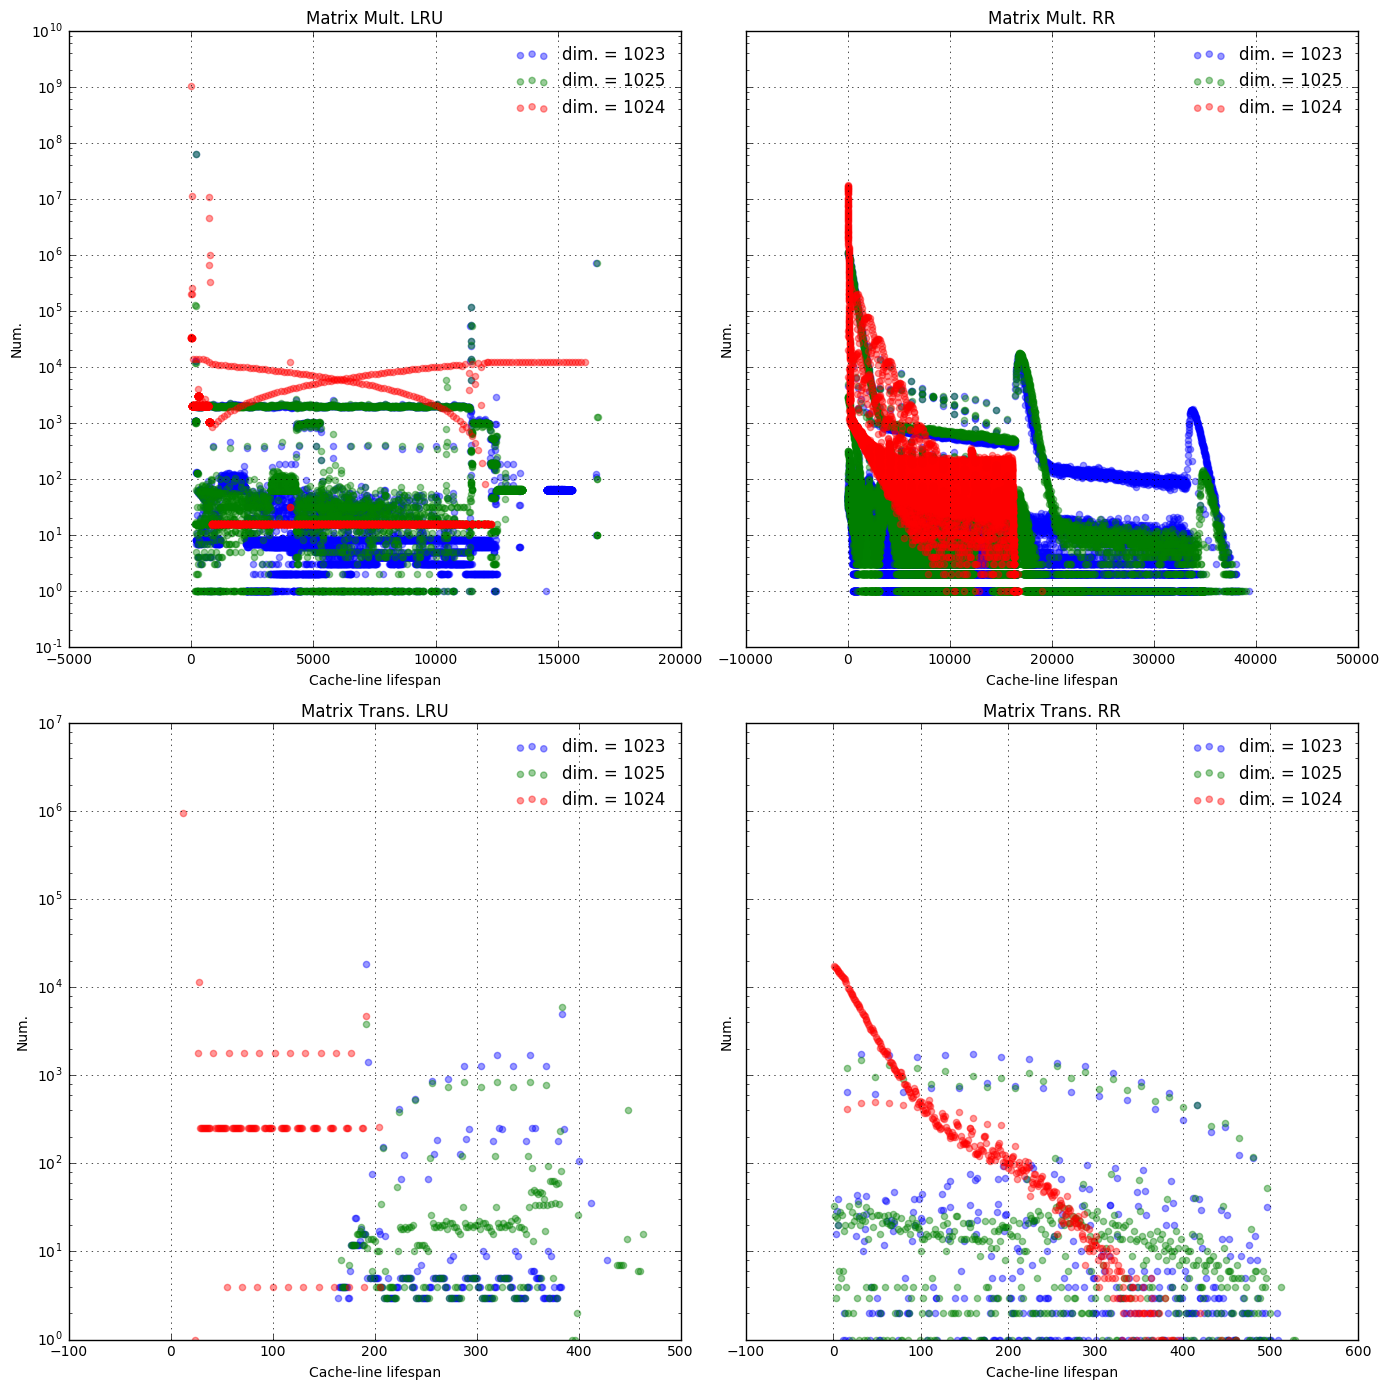

In [3]:
def plot_lifespan_stats(ax, title, stats):
    ax.set_title(title)
    ax.scatter(stats[0][0], stats[0][1], label="dim. = 1023", marker="o", color="blue", alpha=.4)
    ax.scatter(stats[2][0], stats[2][1], label="dim. = 1025", marker="o", color="green", alpha=.4)
    ax.scatter(stats[1][0], stats[1][1], label="dim. = 1024", marker="o", color="red", alpha=.4)
    ax.set_xlabel("Cache-line lifespan")
    ax.set_ylabel("Num.")
    ax.set_yscale("log")
    ax.legend(loc='best', frameon=False)
    ax.grid(True)
    
fig, axes = plt.subplots(2, 2, sharey="row", figsize=(14,14), dpi=100)
plot_lifespan_stats(axes[0][0], "Matrix Mult. LRU", sim_x_lru_stats)
plot_lifespan_stats(axes[0][1], "Matrix Mult. RR", sim_x_rr_stats)
plot_lifespan_stats(axes[1][0], "Matrix Trans. LRU", sim_t_lru_stats)
plot_lifespan_stats(axes[1][1], "Matrix Trans. RR", sim_t_rr_stats)
plt.tight_layout()
plt.show()

На всех графиках можно отметить большое число короткоживущих записей для размерности матриц 1024 (относительно 1023 и 1025). Это прямое следствие использования малого числа кеш-сетов при данной размерности. Данные быстро вытесняются и не доступны для переиспользования. Также для размерности 1024 на графиках с LRU кешем в данных можно выделить сильную функциональную зависимость. Это тоже обусловлено использованием небольшого числа кеш-сетов. В ситуации, когда кеш используется эфффективно (1023, 1025), точки выглядят случайными. Также на графиках наглядно представлено, как переключение с LRU кеша на RR, позволяет "размазывать" данные кеша во времени.